<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v8: Productionising Activity capturing and visualisation
This notebook carries on from v5 with work to productionise the capture and display of unit activation information.

It uses a simple callback, and starts simple with its data collection.

In [6]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
#!cd repo && git checkout c4f0bfe
!cd repo && git pull

import sys
sys.path.append('repo')

import toolkit
from importlib import reload
reload(toolkit)

HEAD is now at feda9e9 Merge remote-tracking branch 'refs/remotes/origin/main'
Already up to date.


<module 'toolkit' from '/content/repo/toolkit.py'>

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit

## Basic setup

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


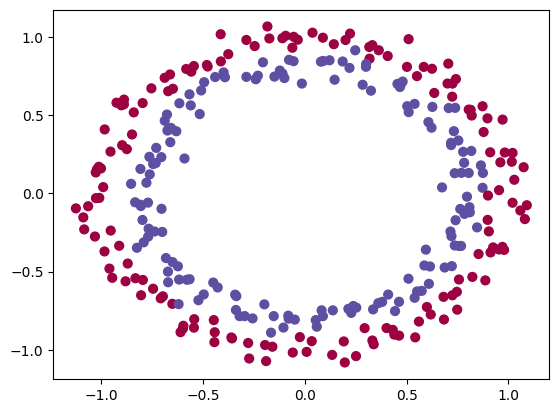

In [9]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

## Unit Activation Rates
Firstly, we're interested not in the floating point range of unit outputs, but rather whether the units are "active" or not. Determined simply by whether the ReLU unit passes the value through, or drops the output and returns `0.0`. For other other activation functions a unit is always considered "active", and that's fine.

In this first cut there's two measures of unit activity that we'll use:
* fraction of "dead units"
  * The percentage of units that are never active - always produce `0.0` as output.
  * This is across all items in the entire training dataset (eg: across all batches).
  * This is also across all spatial coordinates of any CNNs.
* mean rate of activation
  * The mean percentage of units that are active at any given moment in time - having a non-zero output.
  * This will be aggregated down to the channels dimension, and then averaged again (see below).

In both cases, we are primarily interested in the effect on gradient propagation. This means that we treat the tensor axis with a particular interpretation:
* `(B, ..spatial dims.., C)` - batch, spatial, channels
* eg: Simple dense network: `(B, C)`
* eg: 2D CNN: `(B, H, W, C)`
* eg: 3D CNN: `(B, H, W, D, C)` - batch, height, width, depth, channels
* eg: Dense against CNN input - `(B, ..spatial.., C)`
* Aggregated across batch and spatial dims
* Each channel treated separately

Notice that there's precedent for this way of handling the axis in how TF Dense layers handle multi-dimensional input -- they act as a CNN with a 1x1 filter, operating as a dense network across the last axis only, and otherwise sharing weights and repeating against all other axis. In the Dense docs, it refers to treating all those earlier axis as the "batch dimensions".

In practice, as we'll be interested initially only in getting stats across the entire model and for individual layers, processing will thus go as follows:
1. Aggregate "dead units" and "mean activation" across batch and spatial dims, producing a single vector across the channels dimension only.
2. Aggregate across all batches in dataset, still producing a single vector across the channels dimension only.
3. Finally, turn into a scalar as the rates/means across the channels.

Epoch    10 - 224.74ms/epoch: loss: 0.6931  
Epoch    20 - 10.90ms/epoch: loss: 0.6931  
Epoch    30 - 7.70ms/epoch: loss: 0.6931  
Epoch    40 - 9.64ms/epoch: loss: 0.6931  
Epoch    50 - 8.29ms/epoch: loss: 0.6931  
Epoch    60 - 11.04ms/epoch: loss: 0.6931  
Epoch    70 - 11.74ms/epoch: loss: 0.6931  
Epoch    80 - 13.85ms/epoch: loss: 0.6931  
Epoch    90 - 12.71ms/epoch: loss: 0.6931  
Epoch   100 - 11.31ms/epoch: loss: 0.6931  
Total training time: 3.45 secs


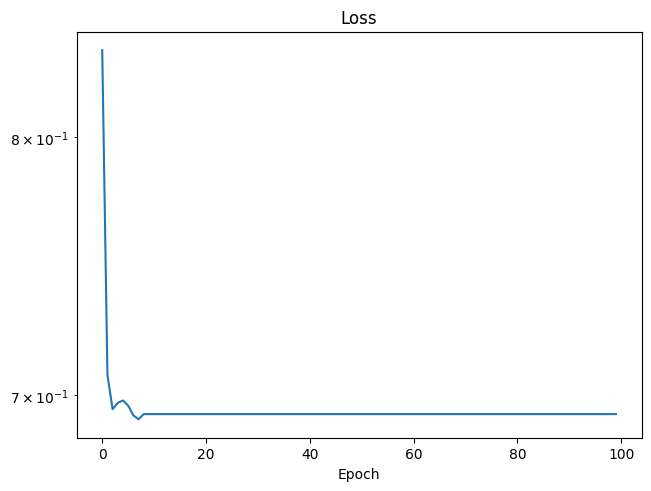

Activity recorded: 
epochs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [17]:
# Attempting via a callback
class ActivityRateCallback(tf.keras.callbacks.Callback):
  def __init__(self, dataset, interval=1, **kwargs):
    """
    Args:
      dataset - dataset to use to measure activity rates at end of each epoch
      interval - sample every N epochs, default: every epoch.
    """
    super(ActivityRateCallback, self).__init__(**kwargs)
    self.dataset = dataset
    self.interval = interval

    # collected stats
    self.epochs = []
    self.model_stats = None
    self.layer_stats = None

  @staticmethod
  def _stat_keys():
    """
    Gets the list of stats that will be computed.
    Currently static but may be computed based on configuration in the future.
    """
    return ['death_rates', 'fractions_active']

  def on_train_begin(self, logs=None):
    """
    Initialises tracking, now that we know the model and number of epochs
    """
    # infer some parameters
    if not hasattr(self.dataset, "_batch_size")
      steps_per_epoch = self.params['steps']
      batch_size = math.ceil(self.dataset.cardinality().numpy() / steps_per_epoch)
      print(f"Dataset not already batched, forcing to batch_size {batch_size}")
      self.dataset = self.dataset.batch(batch_size)

    # init stats
    self.model_stats = {key: [] for key in self._stat_keys()}
    self.layer_stats = []
    for layer in self.model.layers:
        self.layer_stats.append({key: [] for key in self._stat_keys()})

  def on_train_end(self, logs=None):
    """
    Cleans up tracking, and converts everything to numpy arrays for easier consumption.
    """
    self.epochs = np.array(self.epochs)
    for key in self.model_stats.keys():
      lst = [v.numpy() for v in self.model_stats[key]]
      self.model_stats[key] = np.array(lst)
    for l in range(len(self.layer_stats)):
      for key in self.layer_stats[l].keys():
        lst = [v.numpy() for v in self.layer_stats[l][key]]
        self.layer_stats[l][key] = np.array(lst)

  def on_epoch_end(self, epoch, logs=None):
    if epoch % self.interval == 0:
      self._collect_stats(epoch)

  def _collect_stats(self, epoch):
    self.epochs.append(epoch)

    layer_stats = measure_activity_per_layer(self.model, self.dataset)

    # accumulate aggregated stats across entire model
    # TODO, want:
    #  mean_dead_rate: mean of dead_rate across layers
    #  max_dead_rate:  max of dead_rate across layers
    #  mean_activation_rate: mean activation_rate across layers
    #  min_activation_rate: min activation_rate across layers
    #  max_activation_rate: max activation_rate across layers

    # accumulate stats per layer
    for l_idx, stats in enumerate(layer_stats)
      self._append_dict_list(self.layer_stats[l_idx], stats)

  @staticmethod
  def _append_dict_list(dic, addendum_dict):
      for key in addendum_dict.keys():
          dic[key].append(addendum_dict[key])

def list_activity(activity_cb: ActivityRateCallback):
  print(f"Activity recorded: ")
  print(f"epochs: {activity_cb.epochs}")

tf.config.run_functions_eagerly(False)
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
activity = ActivityRateCallback(dataset, interval=1)
history = model.fit(dataset.batch(train_X.shape[0]), epochs=100, verbose=0, callbacks=[toolkit.LessVerboseProgressLogger(), activity])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
#plot_fit(history)

list_activity(activity)



## Appendix: Collecting stats against static model
First, let's just make sure we can cope with some variation in how data is provided.

In [30]:
def do_stuff(model, x, batch_size=None, steps_per_epoch=None):
  """
  Args:
    model: The model to evaluate.
    x: Input data or dataset
    batch_size: Batch size (at least one of this or steps_per_epoch required if x or dataset not already batched).
    steps_per_epoch: Steps per epoch, required if dataset is unbatched.
  """

  # handle variations in how data is supplied
  if isinstance(x, tf.data.Dataset):
    dataset = x
    # ensure dataset has been batched
    if not hasattr(dataset, "_batch_size"):
      if batch_size is None and steps_per_epoch is not None:
        batch_size = int(math.ceil(dataset.cardinality().numpy() / steps_per_epoch))
      if batch_size is not None:
        dataset = dataset.batch(batch_size)
      else:
        raise ValueError("dataset not batched and unable to infer batch size.")
  else:
    if batch_size is None and steps_per_epoch is not None:
      batch_size = int(math.ceil(len(x) / steps_per_epoch))
    if batch_size is None:
      raise ValueError("one of batch_size or steps_per_epoch must be provided when x list/array given.")
    y = tf.zeros((len(x),))  # fake y values
    dataset = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)

  # extract individual layer activations
  monitoring_model = tf.keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])
  inputs, outputs = next(iter(dataset))
  print(f"inputs: {inputs.shape}")
  layer_outputs = monitoring_model(inputs)
  print(f"layer_outputs: {len(layer_outputs)}")

# with raw x
do_stuff(model, train_X, batch_size=32)

# with un-batched dataset
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
do_stuff(model, dataset, batch_size=32)

# with batched dataset
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(32)
do_stuff(model, dataset)

inputs: (32, 2)
layer_outputs: 7
inputs: (32, 2)
layer_outputs: 7
inputs: (32, 2)
layer_outputs: 7


Now the real work.

In [48]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                     │ (None, 100)                 │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 5)                   │             505 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 123,635 (482.95 KB)

 Trainable params: 41,211 (160.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 82,424 (321.97 KB)

In [58]:
def measure_layer_activations(model, x, batch_size=None, steps_per_epoch=None):
  """
  Args:
    model: The model to evaluate.
    x: Input data or dataset
    batch_size: Batch size (at least one of this or steps_per_epoch required if x or dataset not already batched).
    steps_per_epoch: Steps per epoch, required if dataset is unbatched.

  Returns:
    list of dict - dict of stats for each layer, containing:
      dead_rate: fraction of units that are never active
      activation_rate: mean fraction of units that are active at any given moment in time - having a non-zero output
  """

  # handle variations in how data is supplied
  if isinstance(x, tf.data.Dataset):
    dataset = x
    # ensure dataset has been batched
    if not hasattr(dataset, "_batch_size"):
      if batch_size is None and steps_per_epoch is not None:
        batch_size = int(math.ceil(dataset.cardinality().numpy() / steps_per_epoch))
      if batch_size is not None:
        dataset = dataset.batch(batch_size)
      else:
        raise ValueError("dataset not batched and unable to infer batch size.")
  else:
    if batch_size is None and steps_per_epoch is not None:
      batch_size = int(math.ceil(len(x) / steps_per_epoch))
    if batch_size is None:
      raise ValueError("one of batch_size or steps_per_epoch must be provided when x list/array given.")
    y = tf.zeros((len(x),))  # fake y values
    dataset = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)

  # extract individual layer activations
  monitoring_model = tf.keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers])
  inputs, outputs = next(iter(dataset))
  print(f"inputs: {inputs.shape}")
  layer_outputs = monitoring_model(inputs)
  print(f"layer_outputs: {len(layer_outputs)} - {[l.shape for l in layer_outputs]}")

  def _compute_layer_stats(layer_output):
    layer_shape = tf.shape(layer_output)
    batch_and_spatial_count = tf.reduce_prod(layer_shape[:-1])
    channel_count = layer_shape[-1]
    active_outputs = tf.cast(tf.not_equal(layer_output, 0.0), tf.int32)
    active_counts_by_channel = tf.reduce_sum(active_outputs, axis=tf.range(tf.rank(a)-1))
    active_rates = active_counts_by_channel / batch_and_spatial_count
    dead_channels = tf.reduce_sum(tf.cast(tf.equal(active_counts_by_channel, 0), tf.int32)) / channel_count
    #print(f"dead: {dead_channels}, active rates: {active_rates}")
    return {
        'dead_rate': dead_channels.numpy(),
        'activation_rate': tf.reduce_mean(active_rates).numpy()
    }

  def _compute_model_stats(layer_stats):
    res = {}
    for key in ['dead_rate', 'activation_rate']:
      res[f"min_{key}"] = min([stats[key] for stats in layer_stats])
      res[f"max_{key}"] = max([stats[key] for stats in layer_stats])
      res[f"mean_{key}"] = np.mean([stats[key] for stats in layer_stats])
    return res

  layer_stats = [_compute_layer_stats(layer_output) for layer_output in layer_outputs]
  model_stats = _compute_model_stats(layer_stats)
  return model_stats, layer_stats


dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(32)
measure_layer_activations(model, dataset)

inputs: (32, 2)
layer_outputs: 7 - [TensorShape([32, 100]), TensorShape([32, 100]), TensorShape([32, 100]), TensorShape([32, 100]), TensorShape([32, 100]), TensorShape([32, 5]), TensorShape([32, 1])]


({'min_dead_rate': 0.0,
  'max_dead_rate': 1.0,
  'mean_dead_rate': 0.2642857142857143,
  'min_activation_rate': 0.0,
  'max_activation_rate': 1.0,
  'mean_activation_rate': 0.4869196428571429},
 [{'dead_rate': 0.0, 'activation_rate': 0.4996875},
  {'dead_rate': 0.13, 'activation_rate': 0.5159375},
  {'dead_rate': 0.17, 'activation_rate': 0.50125},
  {'dead_rate': 0.27, 'activation_rate': 0.4234375},
  {'dead_rate': 0.28, 'activation_rate': 0.468125},
  {'dead_rate': 1.0, 'activation_rate': 0.0},
  {'dead_rate': 0.0, 'activation_rate': 1.0}])

In [56]:
def compute_model_stats_step(layer_stats):
  res = {}
  for key in ['dead_rate', 'activation_rate']:
    res[f"min_{key}"] = min([stats[key] for stats in layer_stats])
    res[f"max_{key}"] = max([stats[key] for stats in layer_stats])
    res[f"mean_{key}"] = np.mean([stats[key] for stats in layer_stats])
  return res


layer_stats = [
    {
        'dead_rate': 0.1,
        'activation_rate': 0.9
    },
    {
        'dead_rate': 0.3,
        'activation_rate': 0.7
    }
]
compute_model_stats_step(layer_stats)

{'min_dead_rate': 0.1,
 'max_dead_rate': 0.3,
 'mean_dead_rate': 0.2,
 'min_activation_rate': 0.7,
 'max_activation_rate': 0.9,
 'mean_activation_rate': 0.8}

In [52]:
def compute_model_stats(all_layer_stats):
  pass


layer_stats = [
    {
        'dead_rate': [0.0, 0.0, 0.1, 0.2, 0.3],
        'activation_rate': [0.9, 0.8, 0.7, 0.6, 0.5]
    },
    {
        'dead_rate': [0.0, 0.0, 0.0, 0.0, 0.1],
        'activation_rate': [0.7, 0.6, 0.5, 0.4, 0.3]
    }
]
compute_model_stats(layer_stats)


In [41]:
a = tf.constant([[0.5, 0.0, 0.6], [-0.2, 0.9, 0.7]])
tf.equal(a, 0.0)
tf.reduce_sum(tf.cast(tf.equal(a, 0.0), tf.int32), axis=tf.range(tf.rank(a)-1))


<tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 1, 0], dtype=int32)>

In [43]:
a = tf.constant([[0.5, 0.0, 0.6], [-0.2, 0.9, 0.7]])
tf.size(a)

<tf.Tensor: shape=(), dtype=int32, numpy=6>